# Lagrangian Coherent Structure for SCHISM

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10574263.svg)](https://doi.org/10.5281/zenodo.10574263)


<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#000000; border-left: solid #000000 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Objective: </b> Calculation the LCSs for a region. </p>
<p style='margin-left:1em;'>
The main objective of this repository is to calculate the climatological LCSs. However, we found that adding the capability of calculating non-climatological LCS was also useful and an easy step given the main base was already written. Moreover we improved the capability and implemented the code to work with non-structured grids such as SCHISM.  
</p>
<p style='margin-left:1em;'>
Feb - 2024 | Mireya M. Montano, Phellipe Couto | mireya.mmor@gmail.com, phellipe.couto@gmail.com
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>


## Extracting Data
For this SCHISM test we are using data provided by Phellipe Couto (check before publishing, there is probably going to be a THREDDS server link as well)

In [12]:
import os
import glob

files = sorted(glob.glob("../SCHISM/schism_hist_*2018*"))
dirr = os.getcwd()

### Parameters needed
#### File/environment related parameters
In this section we define the file-environment related parameters. Such as:
- month_or_id: In this case, id of the experiment. This is going to define the name of the output directory
- file: path to the file with the velocity fields
- dirr: Working directory where the generated files are going to be saved. In this case we are using the current directory as an example
- vars_dict: Dictionary containing the names associated to the lon, lat and mask variables within the file. SCHISM example:
  - {"lon": "SCHISM_hgrid_node_x", "lat": "SCHISM_hgrid_node_y"}
- domain: choosing a zoom-in domain allows to see a better representation of the coastal or higher resolution dynamics. Provide box limits [lonmin, lonmax, latmin, latmax]

In [13]:
id = "SCHISM_LCS"
climatology = False

vars_dict = {
    "lon": "SCHISM_hgrid_node_x",
    "lat": "SCHISM_hgrid_node_y",
}
# lonmin, lonmax, latmin, latmax indices
domain = [173.4847, 173.7419, -42.5717, -42.3955]

xarray example of data

In [14]:
import xarray as xr

ds = xr.open_dataset(files[0])

ds

<xarray.Dataset>
Dimensions:                  (time: 24, one: 1, nSCHISM_hgrid_face: 235389,
                              nMaxSCHISM_hgrid_face_nodes: 4,
                              nSCHISM_hgrid_edge: 355886, two: 2,
                              nSCHISM_hgrid_node: 120498, sigma: 2,
                              nSCHISM_vgrid_layers: 2)
Coordinates:
  * time                     (time) datetime64[ns] 2018-01-01T01:00:00 ... 20...
  * sigma                    (sigma) float32 -1.0 0.0
Dimensions without coordinates: one, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes,
                                nSCHISM_hgrid_edge, two, nSCHISM_hgrid_node,
                                nSCHISM_vgrid_layers
Data variables: (12/34)
    SCHISM_hgrid             (one) int32 ...
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 ...
    SCHISM_hgrid_edge_nodes  (nSCHISM_hgrid_edge, two) int32 ...
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float32 ...
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float32 ...
    node_bottom_index        (nSCHISM_hgrid_node) int32 ...
    ...                       ...
    salt                     (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    diffusivity              (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    viscosity                (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    TKE                      (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    mixing_length            (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    hvel                     (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, two) float32 ...
Attributes:
    Conventions:   CF-1.0, UGRID-1.0
    title:         SCHISM Model output
    institution:   SCHISM Model output
    source:        SCHISM model output version v10
    references:    http://ccrm.vims.edu/schismweb/
    history:       created by combine_output11
    comment:       SCHISM Model output
    type:          SCHISM Model output
    VisIT_plugin:  https://schism.water.ca.gov/library/-/document_library/vie...

#### Particle release and OpenDrift configuration parameters

In this portion we define the particle release and Opendrfit configuration related parameters. 

Particle release:
- dx (int): Spacing between particles on the x-axis in km. Default: 1 km
- dy (int): Spacing between particles on the y-axis in km. Default 1 km 
- T (int): Timescale to use, use negative timescale if a backward in time simulation is needed
- dt (int): Particle release time step in seconds. Default 6*3600 
- time_step_output (int): If the output of the trajectories is required this will define the output time step in seconds. Default 86400
- z (int): Depth of releases. The LCS are calculated on the surface therefore the value is 0 however these analyses can potentially be done at different depths. 

To estimate non-climatological LCSs (single release) a release time must be provided. 
- **start_release** (pd.datetime): User can define at what point in time releases should start. This start release should be within the time-range of the files provided. Several time-releases can be provided, make sure to activate the `save_daily_CG` parameter to obtain the CG values for each release.

Parameters not needed for non-climatological LCSs
- frequency_of_deployments (int): how often are particle releases made in days. It is better to provide several start_release times than to use this variable.

In [15]:
from datetime import datetime

T = -5  # days
dx = 0.05  # km
dy = 0.05  # km
dt = 900  # seconds
time_step_output = 3600 * 3  # seconds
frequency_of_deployments = None  # days
z = 0  # meters


start_release = [datetime(2018, 1, 15)]


OpenDrift configuration:
- opendrift_reader (str): Reader for the files, see OpenDrift for more information. In this example we use "reader_schism_native"
- **proj_reader** (str): For SCHISM grids, due to the spatial interpolation from triquad grid to regular grid for OpenDrift a projection must be defined to obtain the results.
- opendrift_model (str): OpenDrift module to use. In this example we use "OceanDrift"
- log_level (int): Logging information for Opendrfit. 50 - No information, 20 For a certain amount, 0 for all the debugging
- max_speed (int): maximum speed particles are allowed to reach in m/s. Default 5
- horizontal_diffusivity (int): Particle release horizontal diffusivity. Default: 0.1
- advection_scheme (str): advection scheme of the particle release. Default: "runge-kutta4"

In [16]:
opendrift_reader = "reader_schism_native"
proj_reader = "+proj=tmerc +lat_0=0 +lon_0=173 +k=0.9996 +x_0=1600000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
opendrift_model = "OceanDrift"
log_level = 50  # 50 For no logging information, 20 For a certain amount, 0 for all the debugging
max_speed = 5
horizontal_diffusivity = 0.0
advection_scheme = "runge-kutta4"

Stokes drift can be added to the OpenDrift simulation. 
To activate the user must provide the wave model output, covering the same time range as the hydrodynamic model (SCHISM in this case)
Therefore, the user must provide the following parameters:
- stokes_add (str):  The options are `"add"` or `"only"`. If `"add"` the OpenDrift simulation is going to advect the particles using the hydrodynamic model and the stokes drif. If `"only"` the OpenDrift simulation is only going to take into account the stokes drift. 
- stokes_files (str): path to the files with the stokes drift.
- stokes_reader (str): Reader for the wave files, see OpenDrift for more information. In this example we use "reader_netCDF_CF_unstructured_WWM".

In [17]:
stokes_add = "add"
stokes_files = sorted(glob.glob("../SCHISM/wwm_hist_*2018*"))
stokes_reader = "reader_netCDF_CF_unstructured_WWM"

#### OpenDrift releases and calculation of the Cauchy-Green Tensors.

This class returns a file containing the accumulated values associated with the calculation of the Cauchy-Green Tensors for each run of the chosen month. It can also return a file containing the calculated particle trajectories and the daily Cauchy-Green Tensor estimates, `save_trajectories=True` and `save_daily_CG=True` respectively. 

<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#69337A; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
At the moment wet/dry support is not implemented in opendrift for SCHISM grids. This slows down the efficiency of the code. At the moment one high-resolution release with a 15 minute time step and a dx-dy of 50 meters for 5 day simulations takes about ~20-25 minutes in a personal computer
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>


In [19]:
from cLCS.mean_C import mean_CG


CG = mean_CG(
    dirr,
    files,
    id,
    climatology,
    domain,
    dx,
    dy,
    T,
    dt,
    frequency_of_deployments,
    time_step_output,
    z,
    opendrift_reader,
    opendrift_model,
    vars_dict,
    log_level,
    max_speed,
    horizontal_diffusivity,
    advection_scheme,
    save_trajectories=True,
    save_daily_CG=True,
    start_release=start_release,
    stokes_add=stokes_add,
    stokes_files=stokes_files,
    stokes_reader=stokes_reader,
    #    proj_reader=proj_reader,
)

CG.run()

--- 2018-01-15 00:00:00 Release 1/1
--- Obtaining the final position of particles
--- Calculating Cauchy-Green Tensor
Calculation of LCS done for SCHISM_LCS


#### Squeezelines computation
Using the Cauchy-green calculations this portion of the code computes the squeezelines which are a function of (X,Y)

This code integrates line field from 0 to arclength.

Suggestion: arclength = 150

The output of this class is a file cLCS_%m.p containing the squeezelines (X,Y). Once this file is created there is no need to repeat the process to visualise the cLCSs

For the non-climatological LCS, `climatology` is set to `False` and there's two options. 
If the user specifies the file (`files={id}/LCS_{id}-CG`) only the specified files are goin to be processed. If no files are specified (`files=None`), all the available daily Cauchy-Green files are going to be processed 


<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#E49B0F; border-left: solid #FDDA0D 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
Due to the nature of the SCHISM grid points over land can't be masked as easily. This data is eliminated during this process. However that means it takes longer computation time. Additionaly, this example is using a 392X422 grid, with 165424 particles in total. Taking ~15-20 minutes to calculate in a personal computer. Work in progress to make this step more efficient.
</p></span>
</div>

In [20]:
from cLCS.make_cLCS import compute_cLCS_squeezelines

output_dir = os.path.join(dirr, id)
CG_file = os.path.join(output_dir, f"LCS_{id}_01-CG.p")
squeezelines = compute_cLCS_squeezelines(
    f"{dirr}/",
    id,
    arclength=150,
    climatology=False,
    files=[CG_file],
)

squeezelines.run()

In [22]:
import numpy as np

LCS_file = os.path.join(output_dir, f"LCS_{id}_01.p")
PX, PY = np.load(LCS_file, "rb", allow_pickle=True)

print(
    f"This dataset has {PX.shape[0]} squeezelines with {PX.shape[1]} segments each")

This dataset has 437 squeezelines with 150 segments each


#### Visualisation of cLCSs

This section plots the coloured lines of LCSs returns the fig and ax object. 

Again the working directory and the month being analysed has to be provided. 

Other parameters that can be defined are:
- colourmap (str): Colourmap must be provided, you can chose from one of the options provided on the [README file](https://github.com/MireyaMMO/cLCS/blob/main/README.md#additional-info), or just use a pyplot colormap string.
- lw (int): linewidth. Default 0.8
- fig and/or ax (object): in case the plan is to make a subplot these figures if not a new figure and ax will be created. 
- projection: cartopy associated projection 
- line_spacing (int): to plot every other line (Default: 4)
- save_fig (str): If you want to save the generated figure define the format in which you need the figure (i.e., pdf,svg,png). Default: None 
- corners: if not defined, the script will identify the corners of the domain. [lonmin, lonmax, latmin, latmax]
- climatology (boolean): for non-climatological LCS the value is `False`. Default: `True`. If false the `squeezelines_file` and `CG_file` must be provided.
- **squeezelines_file** (str): LCS file path. i.e., `{id}/LCS_{id}_##.p`
- **CG_file** (str): Cauchy-Green Tensors file path. i.e., `{id}/LCS_{id}_##-CG.p`

---- Generating figure with cartopy features
---- High-resolution Cartopy features added
---- Squeezeline and associated data loaded
---- Saving Figure
---- Done


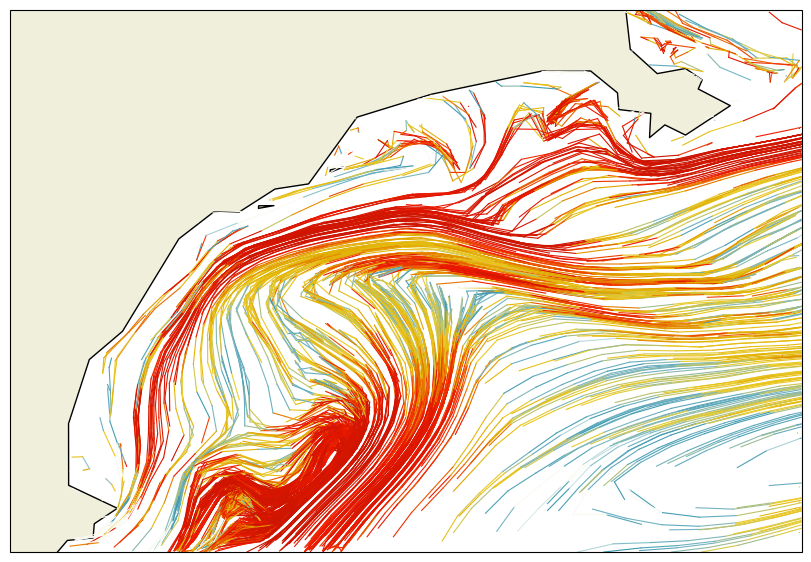

In [24]:
from cLCS.plotting_cLCS import *

fig, ax = cLCSrho_cartopy_colour(
    dirr,
    id,
    colourmap="Zissou",
    fig=None,
    ax=None,
    projection=ccrs.PlateCarree(),
    line_spacing=1,
    save_fig="png",
    corners=domain,
    climatology=False,
    squeezelines_file=LCS_file,
    CG_file=CG_file,
)

If only a quick visualisation is needed or the intensity of the LCS is not relevant there is a faster monochrome option available.

Parameters:
- dirr (str): directory where all the outputs are being saved
- month (int): month that is being analysed 
- fig, ax (object)
- color (str): color requested. Default: 'black'
- alpha (int): as in matplotlib if transparency is needed. Default: 1
- lw (int): linewidth. Default: 0.8
- projection: cartopy associated projection
- line_spacing (int): to make process faster just plot every other line. Default: 1
- save_fig (str): If you want to save the generated figure define the format in which you need the figure (i.e., pdf,svg,png). Default: None (no figure saved). 
- corners: if not defined, the script will identify the corners of the domain. [lonmin, lonmax, latmin, latmax]
- climatology (boolean): for non-climatological LCS the value is `False`. Default: `True`. If false the `squeezelines_file` and `CG_file` must be provided.
- **squeezelines_file** (str): LCS file path. i.e., `{id}/LCS_{id}_##.p`
- **CG_file** (str): Cauchy-Green Tensors file path. i.e., `{id}/LCS_{id}_##-CG.p`

---- Generating figure with cartopy features
---- High-resolution Cartopy features added
---- Saving Figure
---- Done


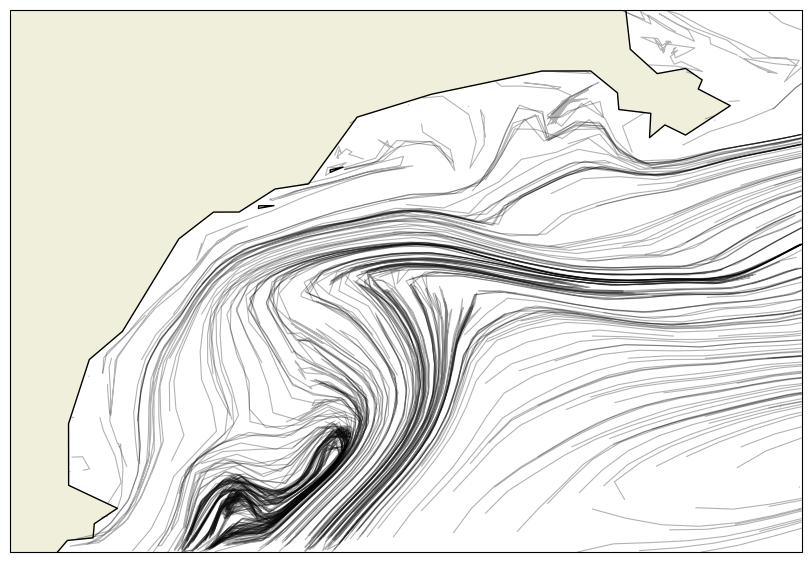

In [23]:
from cLCS.plotting_cLCS import *

fig, ax = cLCSrho_cartopy_monochrome(
    dirr,
    id,
    fig=None,
    ax=None,
    color="k",
    alpha=0.3,
    lw=0.8,
    line_spacing=2,
    projection=ccrs.PlateCarree(central_longitude=180),
    save_fig="png",
    corners=domain,
    climatology=False,
    squeezelines_file=LCS_file,
    CG_file=CG_file,
)